## **Blind Modulation OFDM**

# Carlos Enrique Mosquera Trujillo

# Universidad Nacional de Colombia

En este notebook, se evalúa el uso de las Random Fourier Features (RFF) para la clasificación de modulaciones OFDM (Orthogonal Frequency Division Multiplexing). Se proporciona una implementación paso a paso de un modelo de clasificación utilizando RFF y se compara su rendimiento con otras técnicas de clasificación presentes en el artículo https://ieeexplore.ieee.org/document/9467343.

## Librerías Necesarias

In [ ]:
%%capture
!pip install category_encoders


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:

import numpy as np
from matplotlib import pyplot as plt 
import matplotlib
from scipy.signal import square, sawtooth
from matplotlib import pyplot as plt
import h5py
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Layer, Conv2D, Conv1D, Flatten, Dense, Reshape, Conv2DTranspose,Concatenate
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv1D, Activation, BatchNormalization, Add, Dense,MaxPooling1D,Flatten,Dropout,MaxPooling2D
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import category_encoders as ce
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
matplotlib.rcParams['figure.figsize'] = (20, 6)
matplotlib.rcParams['figure.dpi'] = 90
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.regularizers import l2
import pickle


ModuleNotFoundError: ignored

# Importar datos

In [ ]:
with open('/content/drive/MyDrive/OFDM/complex_data.pkl', 'rb') as f:
    df = pickle.load(f)

In [ ]:
encoder = ce.OrdinalEncoder(cols=['label'])
df = encoder.fit_transform(df)

In [ ]:
X = df.drop(["label","snr"],axis=1)
X = np.array(X.apply(lambda x: np.array([np.imag(x), np.real(x)]).T, axis=1).tolist())
y = df["label"] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

Como núcleo de la TRNN, la TRS consta de una capa convolucional, tres unidades residuales (RU) diferentes y una capa de agrupación máxima. La primera capa convolucional está diseñada para cubrir las características generales con múltiples filtros 1 × 1 y una función de activación lineal. A continuación, se utilizan tres capas UR en serie para aprender características más claramente diferenciadoras. Cada EF tiene una conexión de salto, por lo que las tres EF tienen 3 conexiones. Se añade otra conexión de salto para evitar el sobreajuste cuando se utilizan las tres UR en conjunto. A medida que aumenta la dificultad de la extracción de características, aumenta el número de capas convolucionales de las tres UR. Todas las capas convolucionales de todas los bloues utilizan una función de activación de unidad lineal rectificada con 32 filtros; los tamaños de los filtros son 3 × 2 para TRS1 y 3 × 1 para TRS2∼7, respectivamente. Además, se lleva a cabo una operación de max-pooling para reducir las dimensiones espaciales sin disminuir la calidad de la entrada; tanto el tamaño del pooling como los strides de la capa de max-pooling son 2 × 2 para TRS1 y 2 × 1 para TRS2∼7, respectivamente.



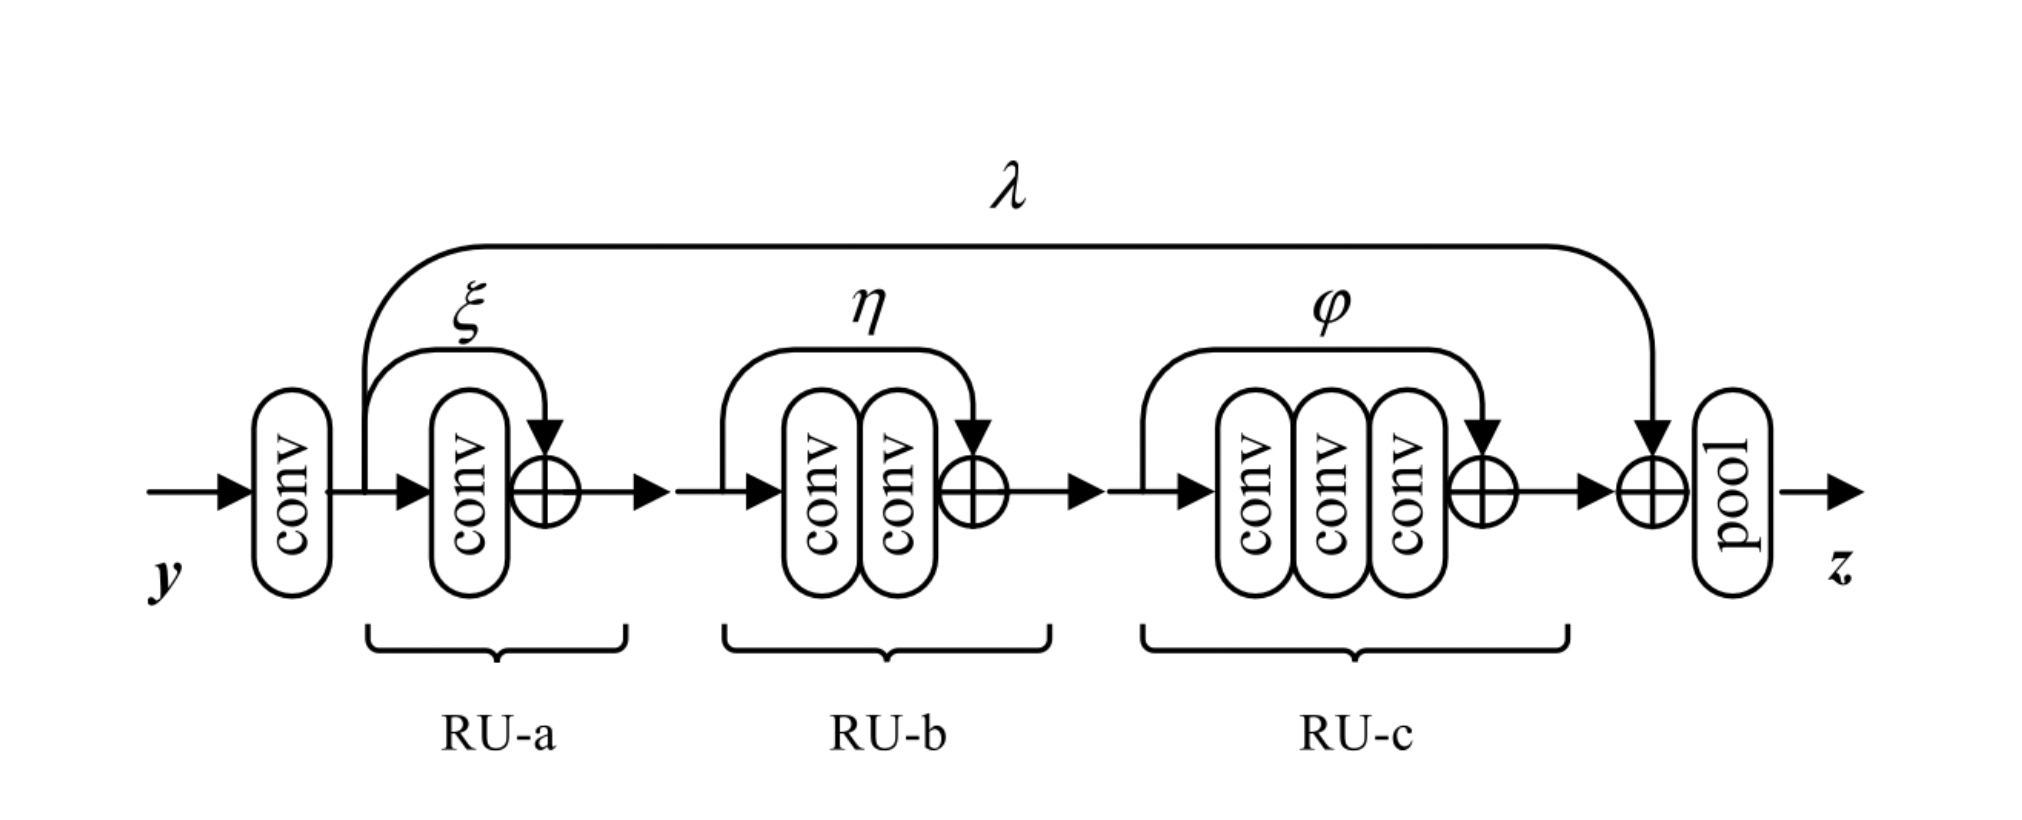

In [ ]:
from keras.regularizers import l2


def TRSN1_(input_layer):
    conv = Conv2D(32, (1,1), padding='same', activation="linear", kernel_regularizer=l2(0.01))(input_layer)
    conv1 = Conv2D(32, (3,2), padding='same', activation="relu", kernel_regularizer=l2(0.01))(conv)
    res1 = Add()([conv, conv1])
    conv2 = Conv2D(32, (3,2), padding='same', activation="relu", kernel_regularizer=l2(0.01))(res1)
    conv4 = Conv2D(32, (3,2), padding='same', activation="relu", kernel_regularizer=l2(0.01))(conv2)
    res2 = Add()([res1, conv4])
    conv5 = Conv2D(32, (3,2), padding='same', activation="relu", kernel_regularizer=l2(0.01))(res2)
    conv6 = Conv2D(32, (3,2), padding='same', activation="relu", kernel_regularizer=l2(0.01))(conv5)
    conv7 = Conv2D(32, (3,2), padding='same', activation="relu", kernel_regularizer=l2(0.01))(conv6)
    res3 = Add()([conv4, conv7])
    res4 = Add()([res3, conv])
    max_pool = MaxPooling2D(pool_size=(2,2))(res4)
    return max_pool

def TRSN(input_layer):
    conv = Conv2D(32, (1,1), padding='same', activation="linear", kernel_regularizer=l2(0.01))(input_layer)
    conv1 = Conv2D(32, (3,1), padding='same', activation="relu", kernel_regularizer=l2(0.01))(conv)
    res1 = Add()([conv, conv1])
    conv2 = Conv2D(32, (3,1), padding='same', activation="relu", kernel_regularizer=l2(0.01))(res1)
    conv4 = Conv2D(32, (3,1), padding='same', activation="relu", kernel_regularizer=l2(0.01))(conv2)
    res2 = Add()([res1, conv4])
    conv5 = Conv2D(32, (3,1), padding='same', activation="relu", kernel_regularizer=l2(0.01))(res2)
    conv6 = Conv2D(32, (3,1), padding='same', activation="relu", kernel_regularizer=l2(0.01))(conv5)
    conv7 = Conv2D(32, (3,1), padding='same', activation="relu", kernel_regularizer=l2(0.01))(conv6)
    res3 = Add()([conv4, conv7])
    res4 = Add()([res3, conv])
    max_pool = MaxPooling2D(pool_size=(2,1))(res4)
    return max_pool
    

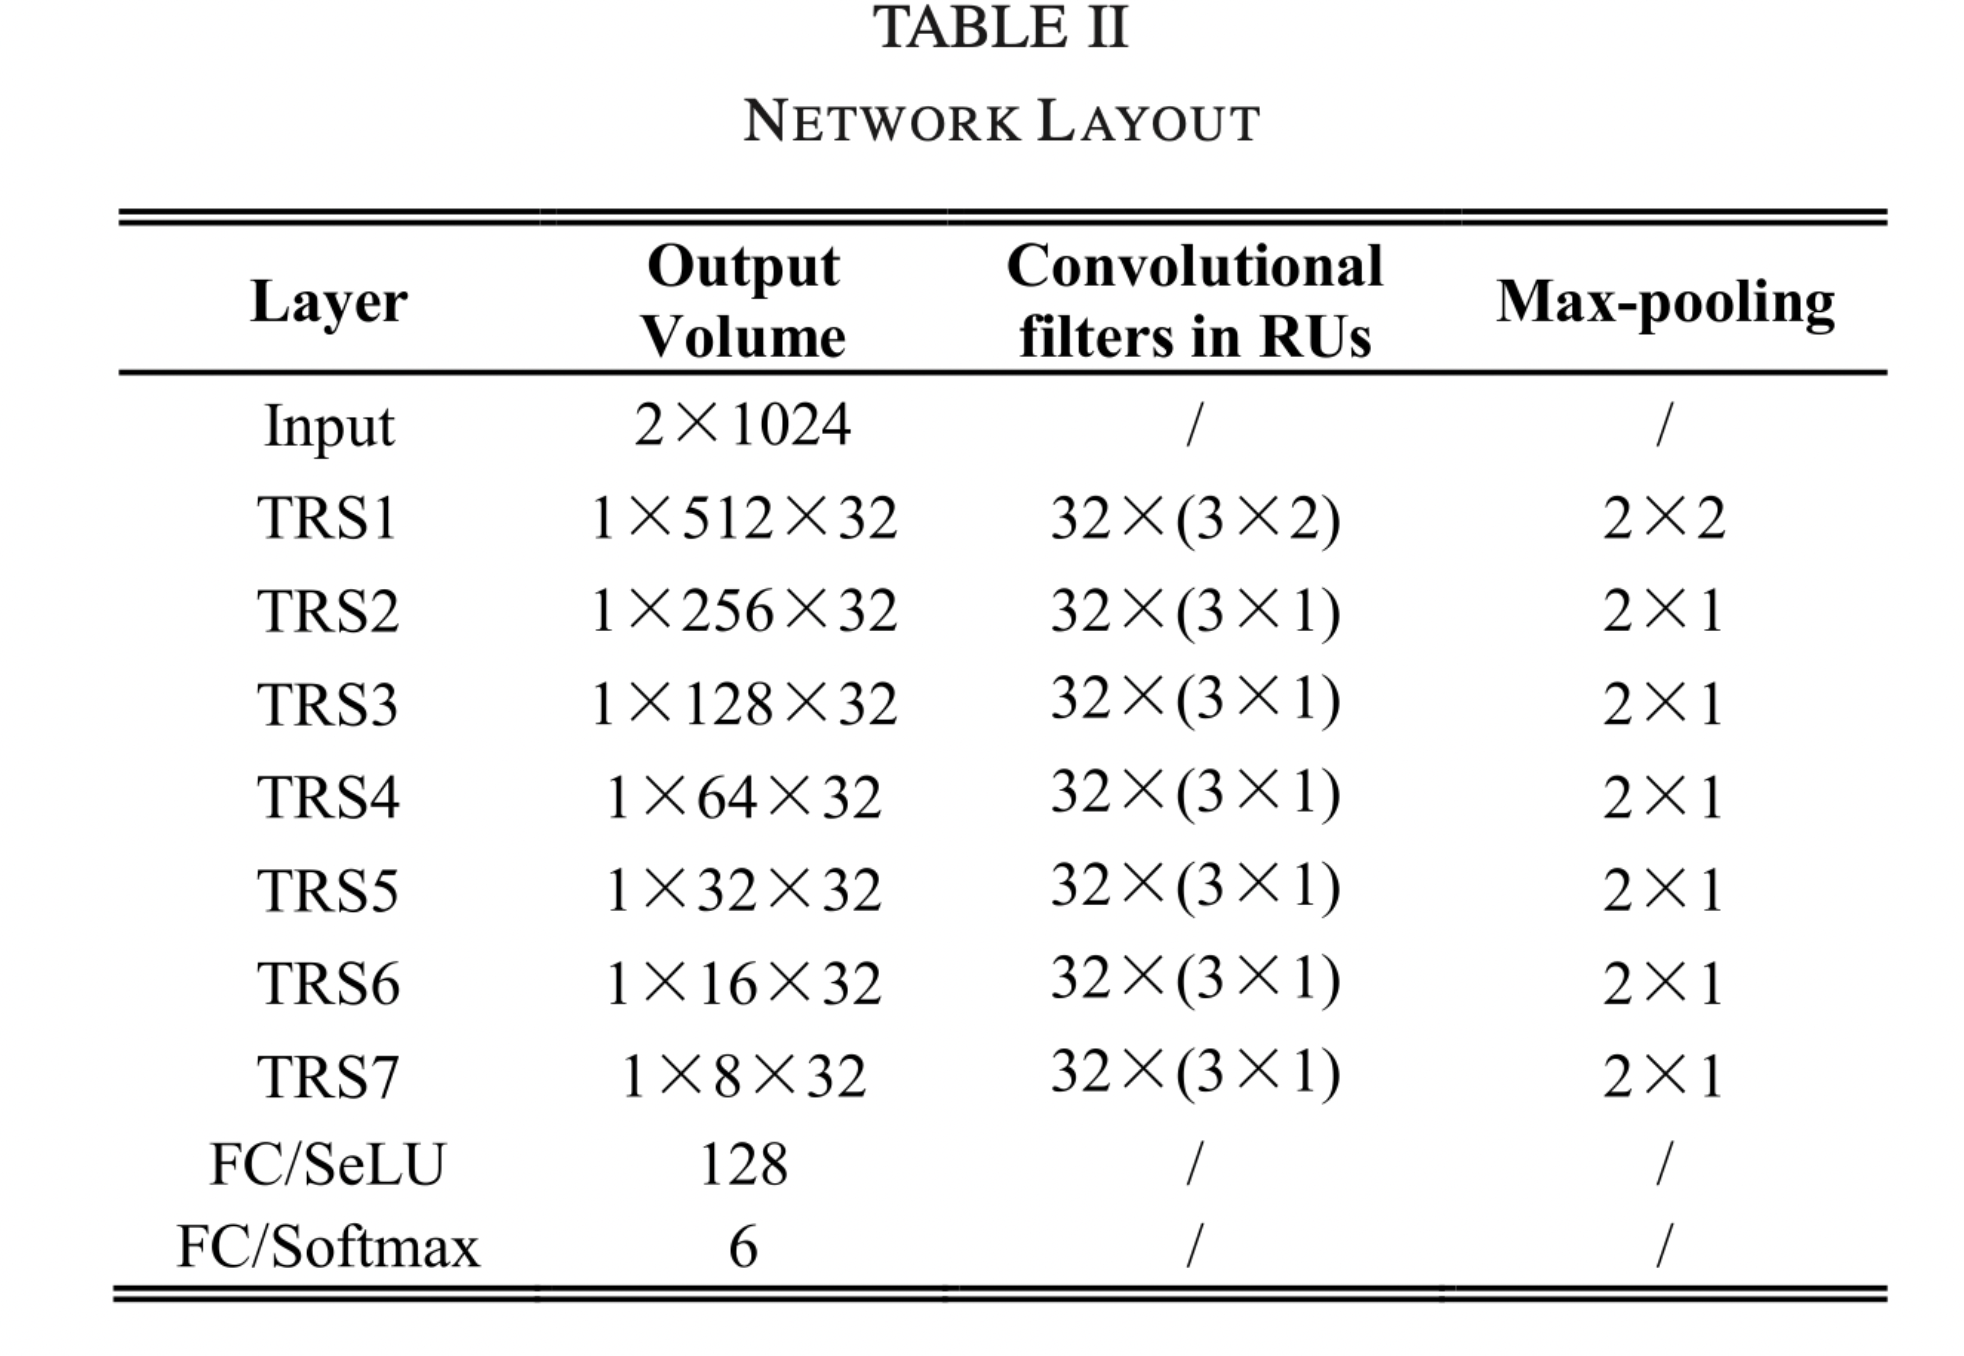

In [ ]:

tf.keras.backend.clear_session()
#tf.debugging.experimental.enable_dump_debug_info(
#    "./logs/debug", tensor_debug_mode="FULL_HEALTH", circular_buffer_size=-1
#)
# Define input shape with complex numbers
input_shape = (1024, 2,1)

# Define input layer for complex data
input_layer = Input(shape=input_shape)

TRSN1 = TRSN1_(input_layer)
TRSN2= TRSN(TRSN1)
TRSN3= TRSN(TRSN2)
TRSN4= TRSN(TRSN3)
TRSN5= TRSN(TRSN4)
TRSN6= TRSN(TRSN5)
TRSN7= TRSN(TRSN6)

flatten = Flatten()(TRSN7)

fc = Dense(128, activation='selu')(flatten)
dropout =Dropout(0.3)(fc)
output = Dense(6, activation='softmax')(dropout)

# Define the model
model = keras.Model(inputs=input_layer, outputs=output)

#model.summary()

NameError: ignored

In [ ]:

model.compile(loss='categorical_crossentropy', metrics=[tf.keras.metrics.Accuracy(),tf.keras.metrics.Precision()],run_eagerly=True,optimizer="adam")


# Define the batch size and number of epochs
batch_size = 1000
epochs = 300

y_train_onehot = tf.one_hot(y_train, 6)
y_test_onehot = tf.one_hot(y_test, 6)

# Train the model using GPU acceleration
with tf.device('/GPU:0'):
    history = model.fit(X_train, y_train_onehot, batch_size=batch_size, epochs=epochs,
                        validation_data=(X_test, y_test_onehot)
    )

Epoch 1/300
81/81 [==============================] - 35s 268ms/step - loss: 13.8082 - accuracy: 0.0000e+00 - precision: 0.5984 - val_loss: 10.8498 - val_accuracy: 0.0000e+00 - val_precision: 0.7722
Epoch 2/300
81/81 [==============================] - 20s 253ms/step - loss: 9.4764 - accuracy: 0.0000e+00 - precision: 0.7226 - val_loss: 8.1955 - val_accuracy: 0.0000e+00 - val_precision: 0.7474
Epoch 3/300
81/81 [==============================] - 20s 252ms/step - loss: 7.3221 - accuracy: 0.0000e+00 - precision: 0.7529 - val_loss: 6.7324 - val_accuracy: 0.0000e+00 - val_precision: 0.7376
Epoch 4/300
81/81 [==============================] - 20s 251ms/step - loss: 6.0358 - accuracy: 0.0000e+00 - precision: 0.7576 - val_loss: 5.4744 - val_accuracy: 0.0000e+00 - val_precision: 0.7838
Epoch 5/300
81/81 [==============================] - 20s 251ms/step - loss: 5.1745 - accuracy: 0.0000e+00 - precision: 0.7521 - val_loss: 5.0706 - val_accuracy: 0.0000e+00 - val_precision: 0.8050
Epoch 6/300
81/81 

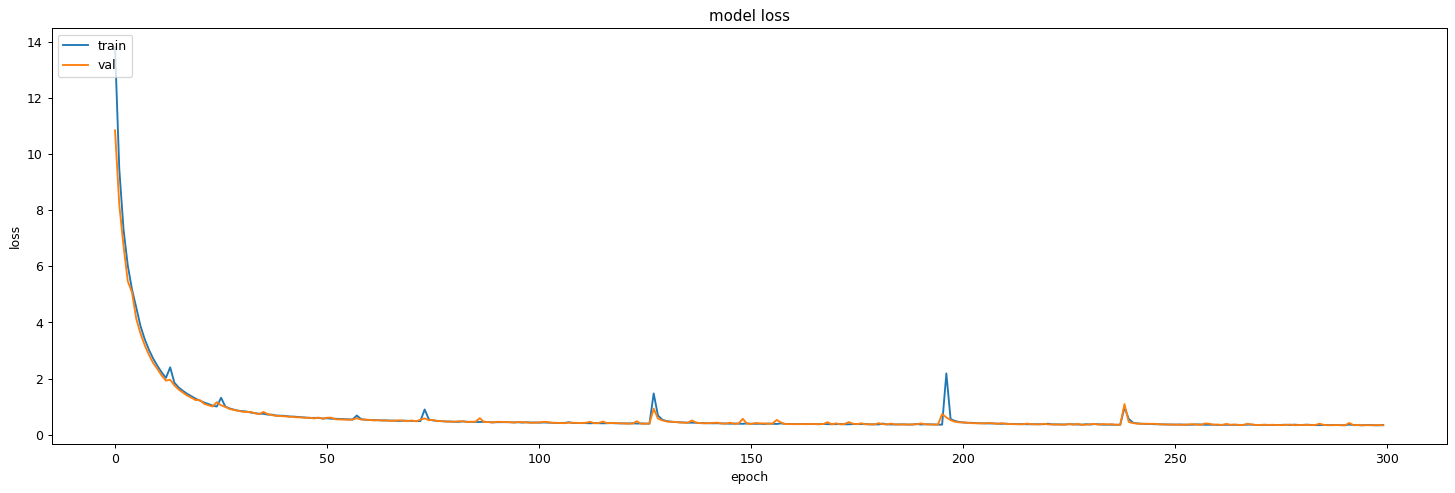

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
with open('/content/drive/MyDrive/OFDM/test_data.pkl', 'rb') as f:
    test = pickle.load(f)
test = encoder.fit_transform(df)
X_test = test.drop(["label","snr"],axis=1)
y_test = test["label"].values
X_test = np.array(X_test.apply(lambda x: np.array([np.imag(x), np.real(x)]).T, axis=1).tolist())
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1) 
print(classification_report(y_test, y_pred))



3581/3581 [==============================] - 183s 51ms/step
              precision    recall  f1-score   support

           1       0.82      0.76      0.79     28644
           2       0.77      0.83      0.80     28644
           3       0.99      0.99      0.99     28644
           4       1.00      1.00      1.00     28644

    accuracy                           0.89    114576
   macro avg       0.89      0.89      0.89    114576
weighted avg       0.89      0.89      0.89    114576



In [ ]:
test["Pred"] = y_pred


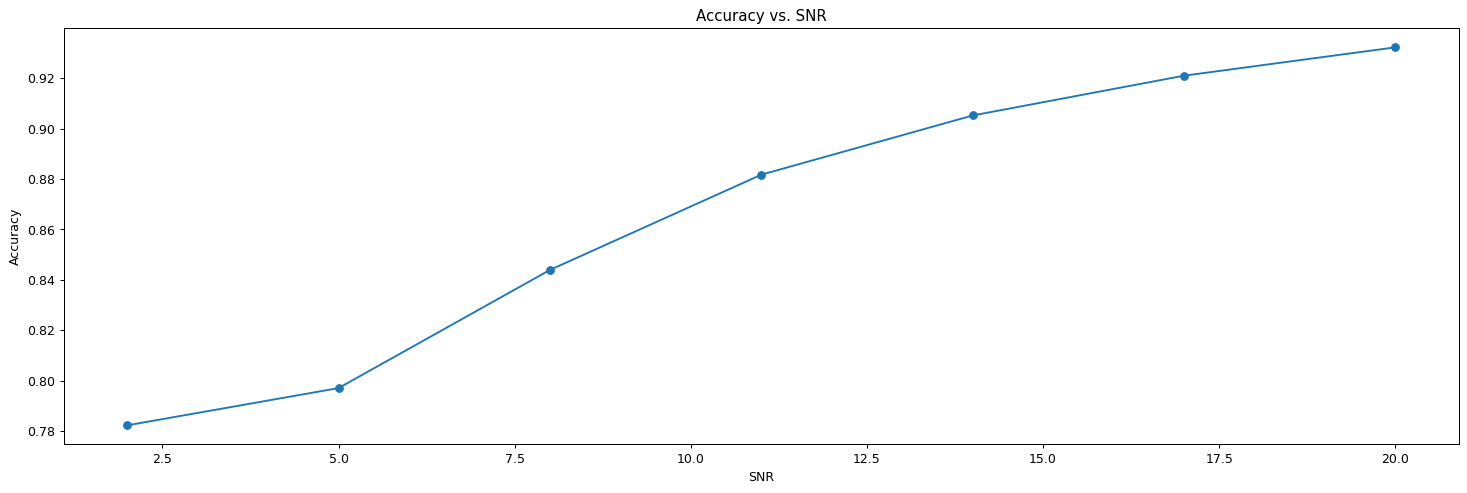

In [ ]:
from sklearn.metrics import accuracy_score

# assuming your dataframe is named 'df'
grouped = test.groupby('snr')

# create lists to store the accuracies and SNRs
accuracies = []
snrs = []

# iterate over each group and calculate the accuracy
for name, group in grouped:
    y_true = group['label']
    y_pred = group['Pred']
    accuracy = accuracy_score(y_true, y_pred)
    accuracies.append(accuracy)
    snrs.append(name)

# plot the accuracies vs. SNRs
plt.plot(snrs, accuracies, '-o')
plt.xlabel('SNR')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. SNR')
plt.show()

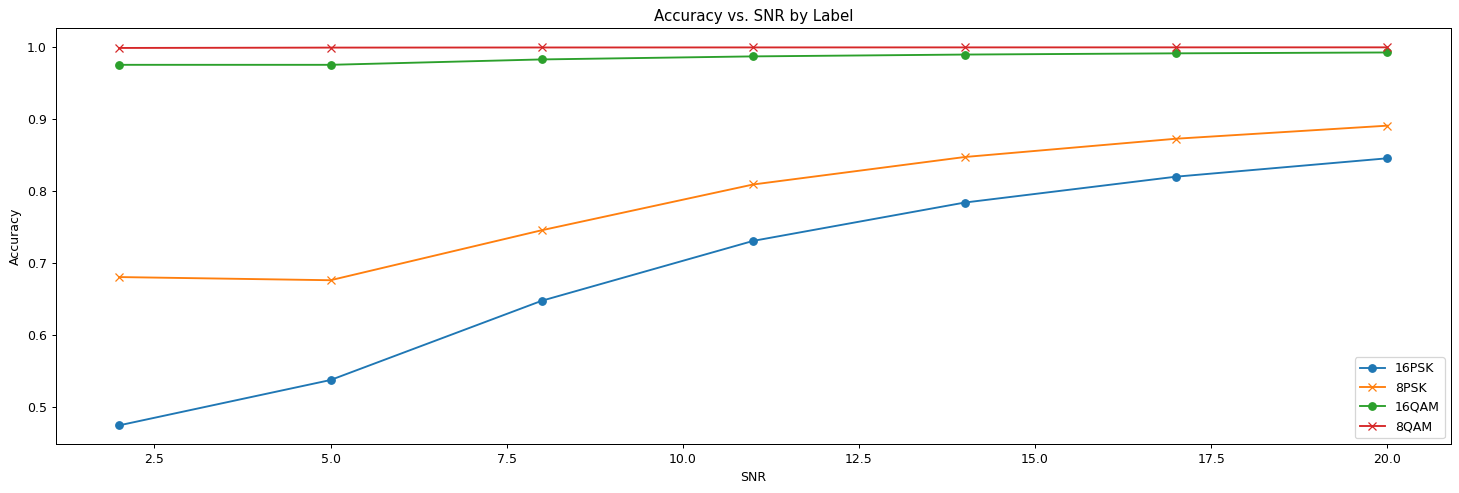

In [ ]:

grouped = test.groupby(['snr', 'label'])

# create dictionaries to store the accuracies for each label at each SNR level
accuracies = {1: [], 2: [], 3: [], 4: []}  # assuming there are four labels: 0, 1, 2, 3
snrs = []

# iterate over each group and calculate the accuracy
for (snr, label), group in grouped:
    y_true = group['label']
    y_pred = group['Pred']
    accuracy = accuracy_score(y_true, y_pred)
    accuracies[label].append(accuracy)
    if snr not in snrs:
        snrs.append(snr)

# plot the accuracies vs. SNRs for each label
plt.plot(snrs, accuracies[1], '-o', label='16PSK')
plt.plot(snrs, accuracies[2], '-x', label='8PSK')
plt.plot(snrs, accuracies[3], '-o', label='16QAM')
plt.plot(snrs, accuracies[4], '-x', label='8QAM')
plt.xlabel('SNR')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. SNR by Label')
plt.legend()
plt.show()


In [ ]:
cm = confusion_matrix(y_test, y_pred,normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

ValueError: ignored